In [1]:
import jax
from jax import numpy as jnp, jit, vmap, random
from jaxmarl import make
from jaxmarl.environments.smax import map_name_to_scenario
from jaxmarl.environments.smax.smax_env import State as SMAXState  # use to unstack state carry from lax scan
from jaxmarl.environments.smax.heuristic_enemy import HeuristicPolicyState as EnemyState
from jaxmarl.environments.smax.heuristic_enemy_smax_env import State as State

from functional import partial
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from copy import deepcopy

import esch

## Environment

In [2]:
def make_vtraj(config):  # returns a function that runs n_envs environments in parallel. Current actions are random.
    env = make(config['env'], **config['env_config'])
    config['n_agents'] = env.num_agents * config['n_envs']

    def init_runner_state(key):
        key, key_reset = random.split(key)
        key_reset      = random.split(key_reset, config['n_envs'])
        obsv, state    = vmap(env.reset)(key_reset)
        return (state, obsv, key)

    def env_step(runner_state, seqs):
        env_state, last_obs, key = runner_state   # random key for sampling actions
        key, key_act             = random.split(key)

        key_act = random.split(key_act, config['n_agents']).reshape((env.num_agents, config['n_envs'], -1))
        # this is the line we wanna inject the action into from.
        actions = {agent: vmap(env.action_space(agent).sample)(key_act[i]) for i, agent in enumerate(env.agents)}

        key, key_step = random.split(key)
        key_step      = random.split(key_step, config['n_envs'])

        obsv, env_state, reward, done, infos = vmap(env.step)(key_step, env_state, actions)
        return (env_state, obsv, key), (key_step, env_state, actions)  # reward)



    def vtraj_fn(key):
        key, key_init       = random.split(key)
        runner_state        = init_runner_state(key_init)
        # scan :: (c -> a -> (c, b)) -> c -> [a] -> (c, [b])
        runner_state, hist = jax.lax.scan(env_step, runner_state, None, length=config['max_steps'])
        return runner_state, hist

    return vtraj_fn, env

In [3]:
map_name       = '8m'
config         = {"max_steps": 100, "n_envs": 9, "env": "HeuristicEnemySMAX", "env_config": {'scenario': map_name_to_scenario(map_name)}}
vtraj_fn, env  = make_vtraj(config)
vtraj          = jit(vtraj_fn)

In [4]:
rng, key                = random.split(random.PRNGKey(0))
(state, obs, key), hist = vtraj(key)

KeyboardInterrupt: 

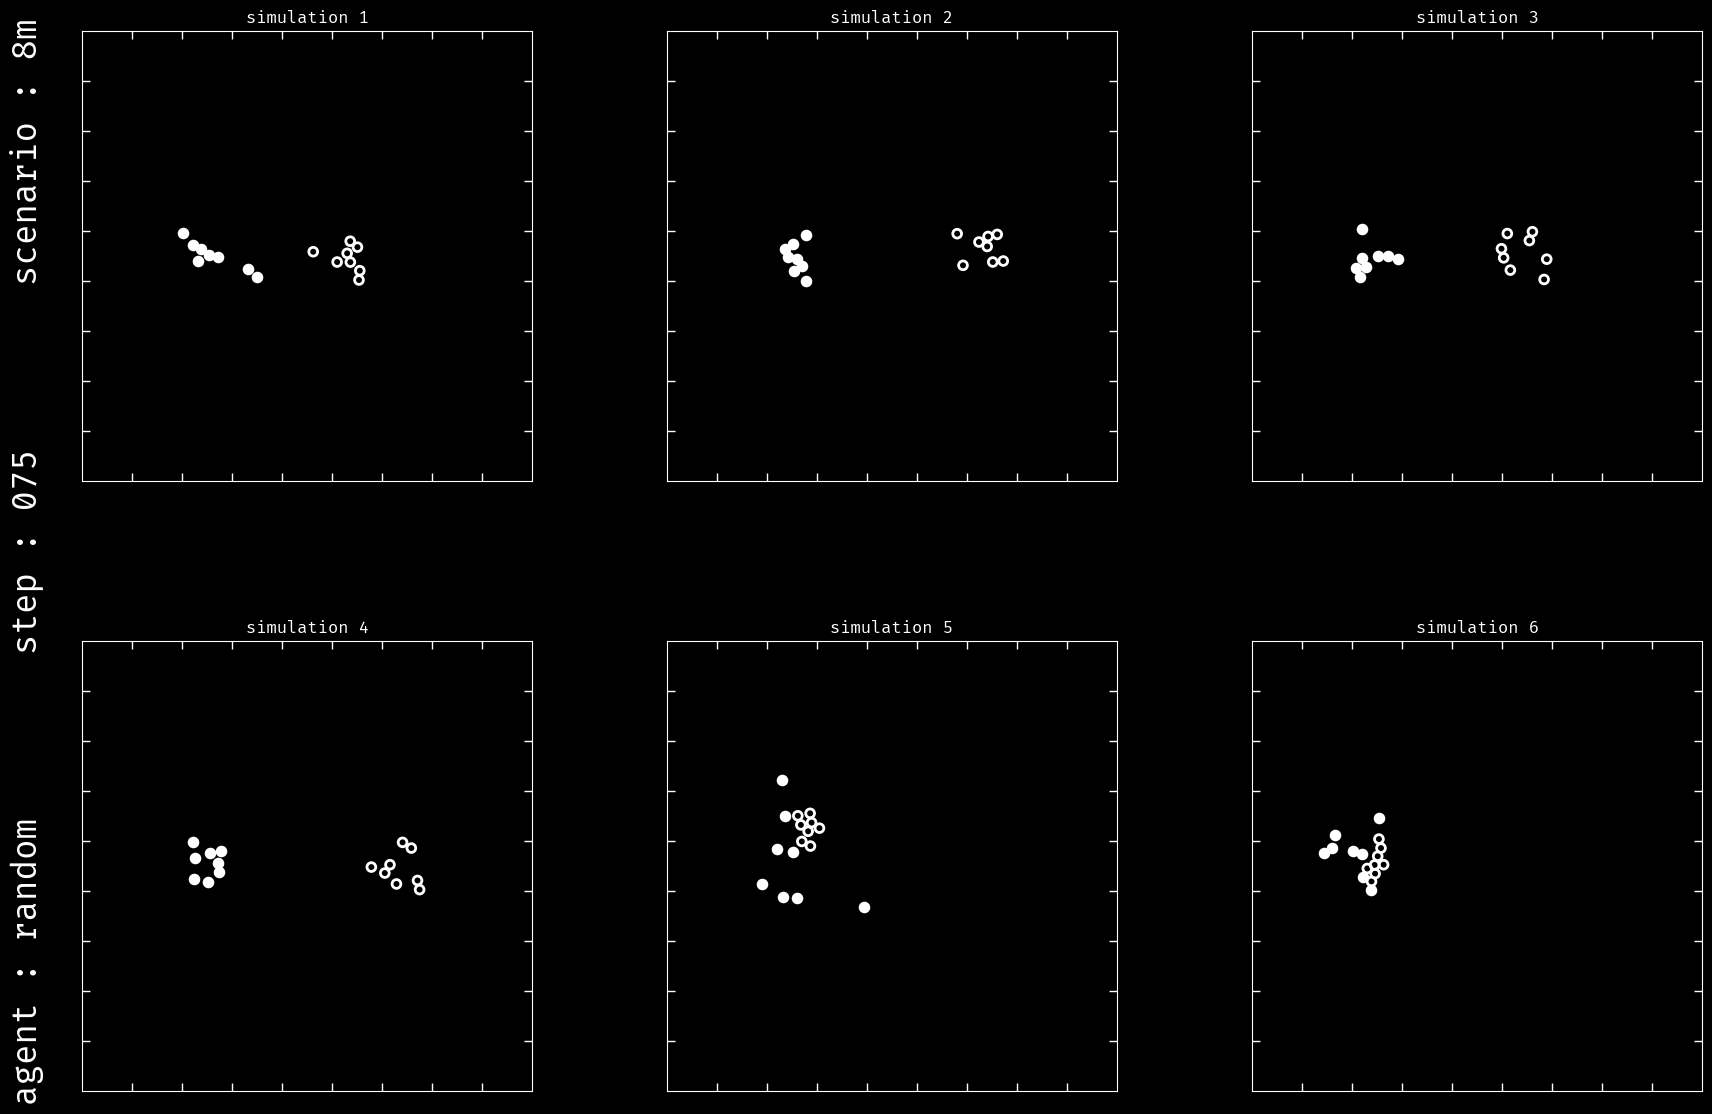

In [ ]:
def expand_state_seq_fn(env, hist):
    xs = []
    for i in range(config['max_steps']):
        state = SMAXState(
            unit_positions=hist[1].state.unit_positions[i, :],
            unit_types=hist[1].state.unit_types[i, :],
            unit_teams=hist[1].state.unit_teams[i, :],
            unit_health=hist[1].state.unit_health[i, :],
            unit_weapon_cooldowns=hist[1].state.unit_weapon_cooldowns[i, :],
            prev_actions=hist[1].state.prev_actions[i, :],
            time=hist[1].state.time[i],
            terminal=hist[1].state.terminal[i],
            unit_alive=hist[1].state.unit_alive[i, :]
        )
        state = State(
            state=state,
            enemy_policy_state=EnemyState(
                default_target=hist[1].enemy_policy_state.default_target[i],
                last_attacked_enemy=hist[1].enemy_policy_state.last_attacked_enemy[i]
            )
        )
        action = {
            ally: actions[i] for ally, actions in hist[2].items()
        }
        xs.append((hist[0][i], state, action))
    return vmap(env.expand_state_seq)(xs)

seqs = expand_state_seq_fn(env, hist)

## behavior tree

In [ ]:
""" 
# Define a basic action node
def leaf_fn(state, condition):
    return jnp.array(state[0] > state[1]), state

# Define a selector node (returns success if any child succeeds)
def node_fn(nodes, state, kind='selector'):
    # success, state = [leaf(s) for leaf, s in zip(nodes, state)], []
    # vmap over nodes and states
    return success, state  # jnp.any(success), state if kind == 'selector' else jnp.all(success), state

# Example usage
def tree_fn(state):
    return node_fn([leaf_fn for _ in range(config['n_agents'])], state)
    
key, key_init  = random.split(key)
key_init       = random.split(key_init, config['n_agents'])
success, state = tree_fn(key_init)
success """;

" \n# Define a basic action node\ndef leaf_fn(state, condition):\n    return jnp.array(state[0] > state[1]), state\n\n# Define a selector node (returns success if any child succeeds)\ndef node_fn(nodes, state, kind='selector'):\n    # success, state = [leaf(s) for leaf, s in zip(nodes, state)], []\n    # vmap over nodes and states\n    return success, state  # jnp.any(success), state if kind == 'selector' else jnp.all(success), state\n\n# Example usage\ndef tree_fn(state):\n    return node_fn([leaf_fn for _ in range(config['n_agents'])], state)\n    \nkey, key_init  = random.split(key)\nkey_init       = random.split(key_init, config['n_agents'])\nsuccess, state = tree_fn(key_init)\nsuccess "

In [ ]:
esch.worlds_fn(seqs, {"agent": 'random', "scenario": map_name})

(9, 16, 2)